In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pygstat import boise_prior
import time
from scipy import io

In [2]:
DATA = io.loadmat('Project_BHRS.mat')
G = DATA['G_fat']
#x = DATA['x']
#y = DATA['y']
d_obs = DATA['traveltimes'].flatten()
d_std = DATA['traveltimes_std'].flatten()
nd = len(d_obs)
nx = DATA['nx'].flatten()[0]
ny = DATA['ny'].flatten()[0]
x = DATA['x'].flatten()
y = DATA['y'].flatten()
sources = DATA['sources'].flatten()
receivers = DATA['receivers'].flatten()

Text(0.5, 1.0, 'One realization')

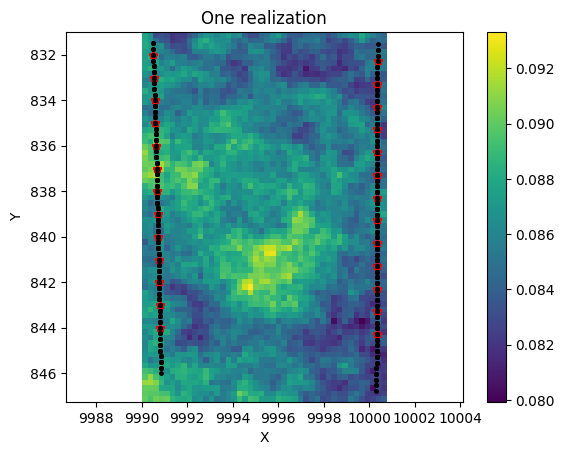

In [3]:

# Plot models and data
m, O = boise_prior()
plt.figure()
plt.imshow(m, extent=[x[0], x[-1], y[0], y[-1]])
plt.plot(DATA['sources'][:, 0], DATA['sources'][:, 1], 'r*')
plt.plot(DATA['receivers'][:, 0], DATA['receivers'][:, 1], 'k.', markersize=5)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.gca().invert_yaxis()
plt.axis('equal')
plt.title('One realization')

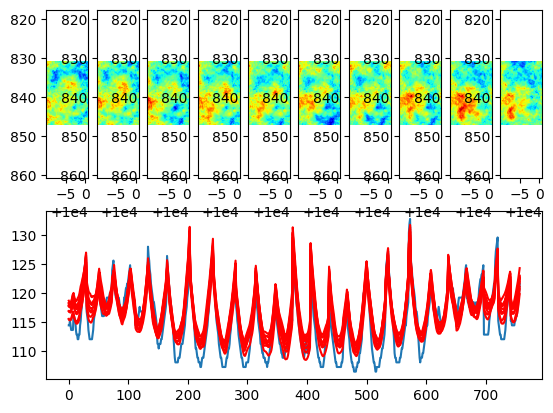

In [4]:
plt.figure()
plt.subplot(2, 1, 2)
plt.plot(d_obs.flatten())
for i in range(10):
    m, O = boise_prior(m, 0.3, O)

    d = G.dot(1.0 / m.flatten('F'))

    plt.subplot(2, 10, i+1)
    plt.imshow(m, extent=[x[0], x[-1], y[-1], y[0]], vmin=0.076, vmax=0.094, cmap='jet')
    plt.axis('equal')

    plt.subplot(2, 1, 2)
    plt.plot( d, 'r-')

plt.show()

/tmp/ipykernel_706332/905081106.py:28: RuntimeWarning: overflow encountered in exp
  P_acc = np.exp(logL_pro - logL_cur) ** (1 / T)


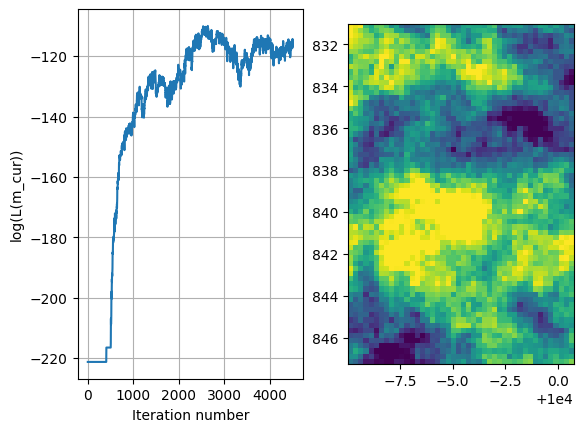

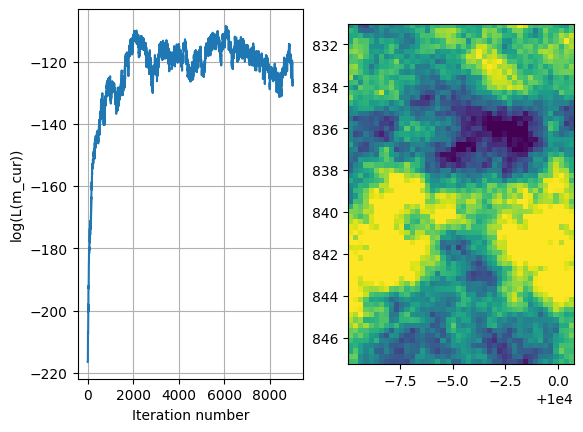

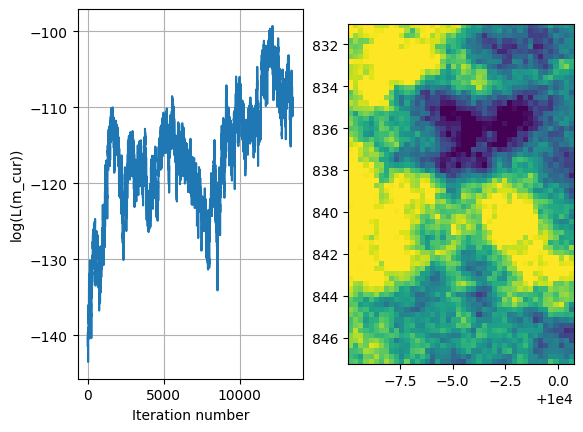

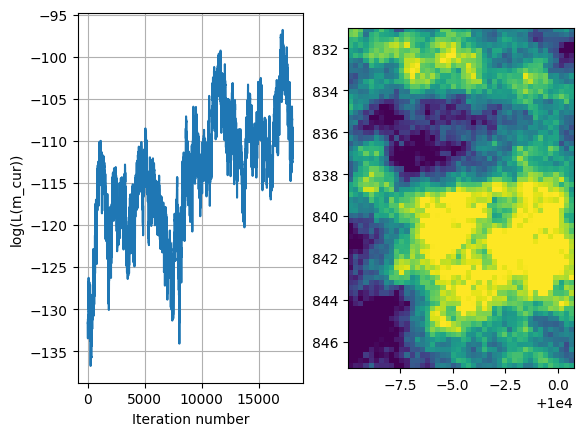

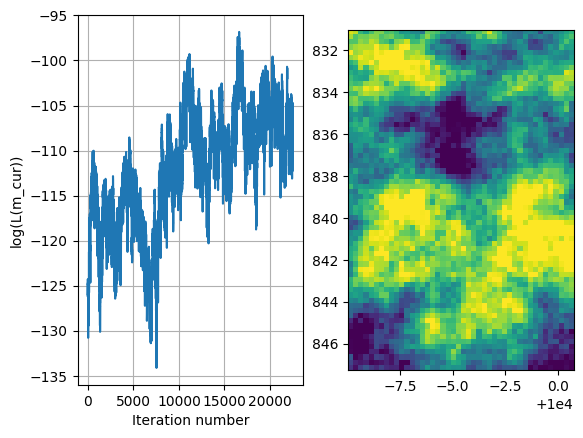

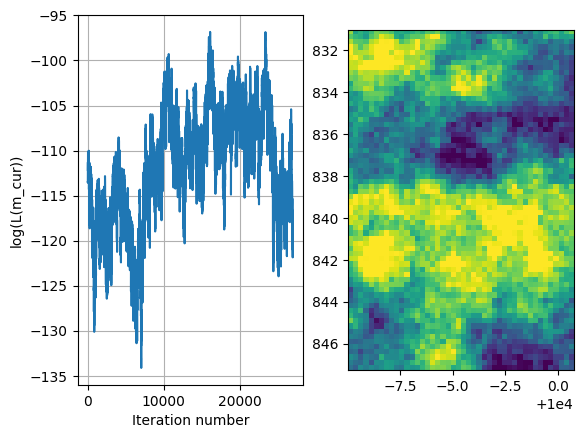

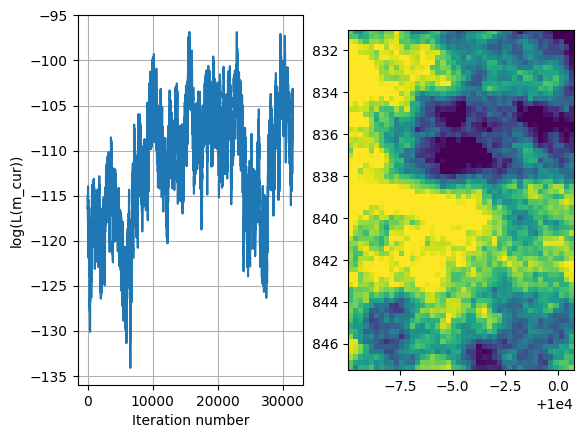

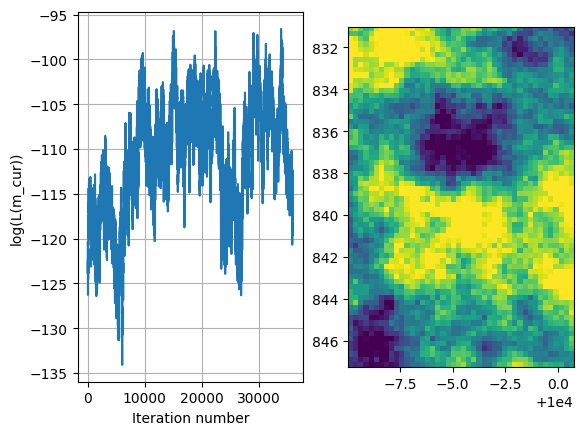

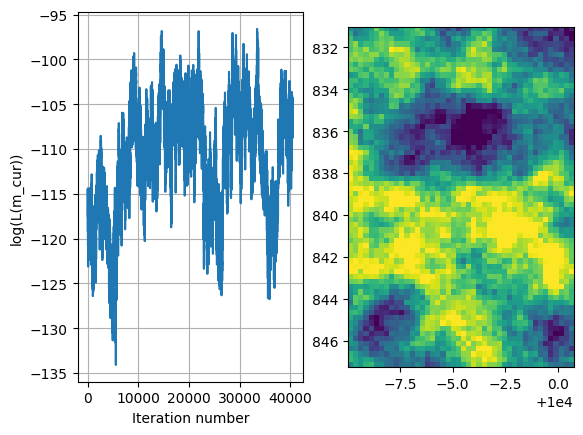

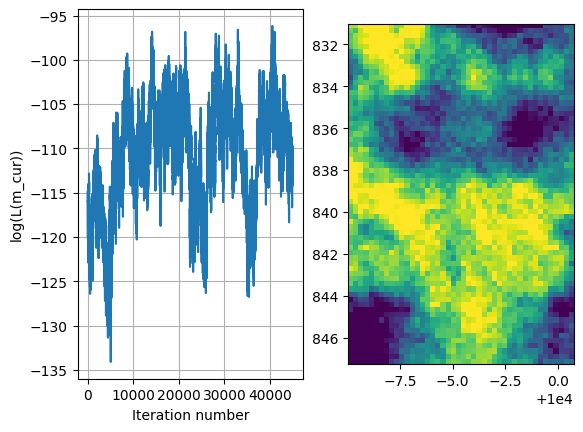

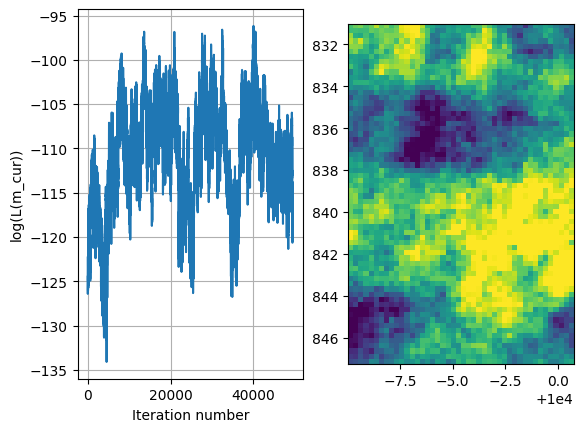

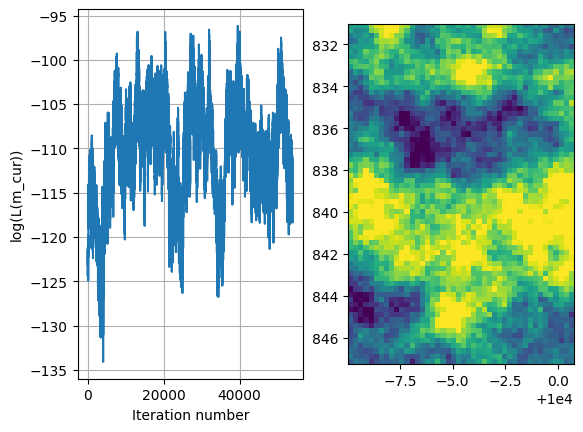

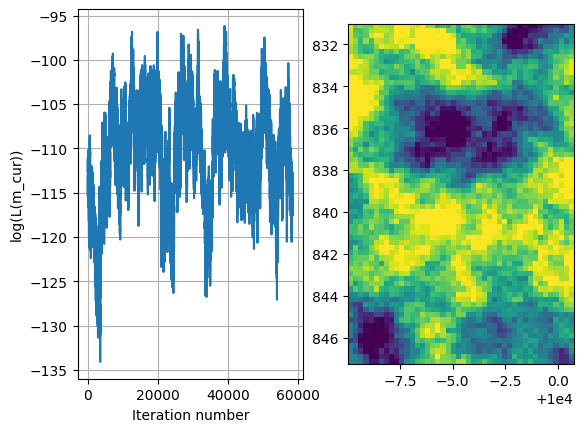

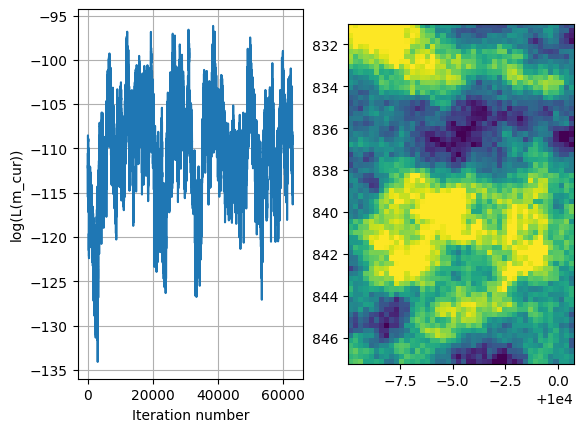

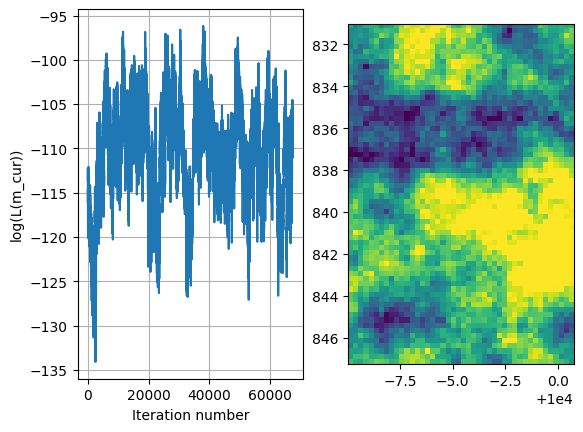

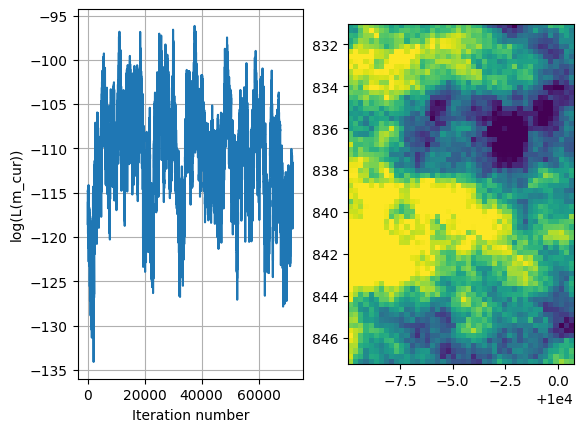

9214963.117218 it/s, Average Acceptance: 36730/80000


In [5]:
N = 80000
Nacc = 0

T = 1
step = 0.05
logL_post = np.zeros(N)

m_cur, O = boise_prior()
d_cur = G.dot(1.0 / m_cur.flatten('F'))
logL_cur = (-0.5 * np.sum((d_cur - d_obs) ** 2 / d_std ** 2))
m_post = np.zeros((ny, nx, N))
t0=time.time()
for i in range(N):
    step = 0.03 
    if i < 1000:
        step = 0.5

    # sample prior
    m_pro, O = boise_prior(m_cur, step, O)

    # forward response
    d_pro = G.dot(1.0 / m_pro.flatten('F'))

    # likelihood
    logL_pro = (-0.5 * np.sum((d_pro - d_obs) ** 2 / d_std ** 2))

    # Accept move in Markov chain
    P_acc = np.exp(logL_pro - logL_cur) ** (1 / T)

    # Accept all? (to sample the prior)
    # P_acc = 1

    if np.random.rand() < P_acc:
        m_cur = m_pro.copy()
        logL_cur = logL_pro.copy()
        Nacc += 1

    m_post[:, :, i] = m_cur
    logL_post[i] = logL_cur

    if (i+1) % 5000 == 0:
        plt.subplot(1, 2, 1)
        i1 = int(np.ceil(int(i / 10)))
        plt.plot(logL_post[i1:i])
        plt.xlabel('Iteration number')
        plt.ylabel('log(L(m_cur))')
        plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.imshow(m_cur, extent=[x[0], x[-1], y[-1], y[0]])
        #plt.gca().invert_yaxis()
        plt.clim(0.08, 0.09)
        plt.draw()
        plt.show()
t1=time.time()
t_elaps = (t1 - t0) * 3600 * 24
print('%f it/s, Average Acceptance: %d/%d' % (t_elaps,Nacc,N) )

In [6]:
i_burnin = 4000
m_post = m_post[:, :, i_burnin:]

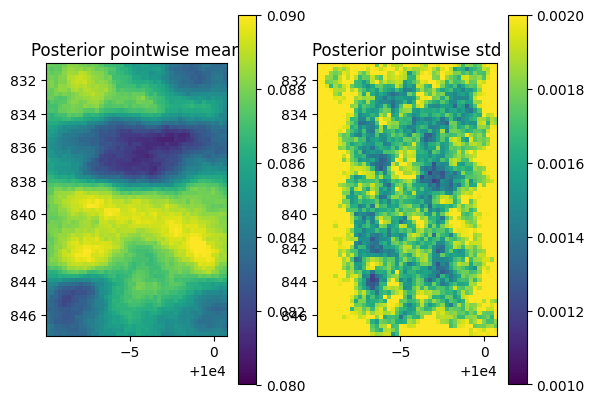

In [7]:
m_post_mean = np.mean(m_post[:,:,0:i], axis=2)
m_post_std = np.std(m_post[:,:,0:i], axis=2)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(m_post_mean, extent=[x[0], x[-1], y[-1], y[0]])
plt.title('Posterior pointwise mean')
#plt.gca().invert_yaxis()
plt.clim(0.08, 0.09)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(m_post_std, extent=[x[0], x[-1], y[-1], y[0]])
plt.title('Posterior pointwise std')
#plt.gca().invert_yaxis()
plt.clim(1e-3, 2.0e-3)
plt.colorbar()
plt.show()

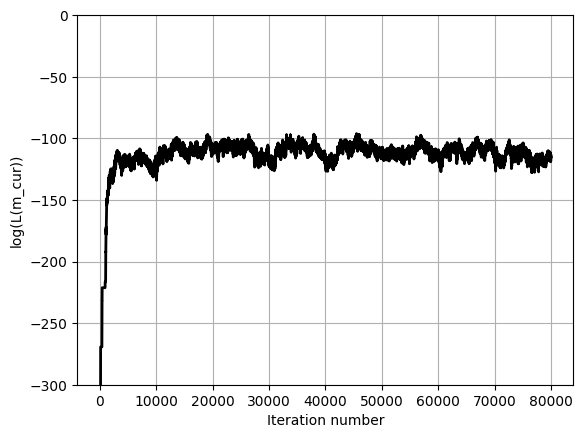

In [8]:
plt.figure()
plt.plot(logL_post, 'k-', linewidth=2)
plt.xlabel('Iteration number')
plt.ylabel('log(L(m_cur))')
plt.grid(True)
plt.ylim(-300, 0)
plt.savefig('boise_logL_10000_tight.png')

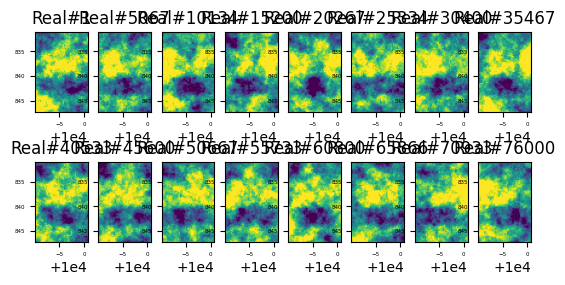

In [9]:
plt.figure()
iplot = np.linspace(1, m_post.shape[2], 16, dtype=int)
for i in range(len(iplot)):
    plt.subplot(3, 8, i+1)
    plt.imshow(m_post[:, :, iplot[i]-1], extent=[x[0], x[-1], y[0], y[-1]])
    plt.title(f'Real#{iplot[i]}')
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)
    plt.clim(0.08, 0.09)
plt.savefig(f'boise_post_reals_{iplot[0]}_{iplot[-1]}.png')

P(TWIP > 30) = 0.31


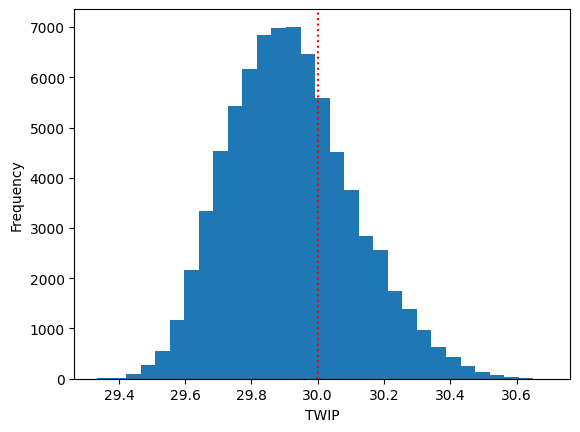

In [10]:
iy = np.where(y < 844)[0]
dxy = (x[1] - x[0]) * (y[1] - y[0])
TWIP = np.zeros(m_post.shape[2])
for i in range(m_post.shape[2]):
    por = np.exp(m_post[:, :, i] * (-41.7) + 2.03)
    TWIP[i] = np.sum(dxy * por[iy, :])

TWIP_lev = 30
plt.figure()
plt.hist(TWIP, bins=31)
plt.axvline(TWIP_lev, color='r', linestyle=':')
plt.xlabel('TWIP')
plt.ylabel('Frequency')
plt.savefig('boise_rej_twip.png')

ip = np.where(TWIP > TWIP_lev)[0]
Ptwip = len(ip) / m_post.shape[2]
print(f'P(TWIP > {TWIP_lev}) = {Ptwip:.2f}')